In [21]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from img_utils import *
path = "../nybolig-scrape/output"
houses_df_ = data_to_DF(path, max_houses=1000)

2024-04-16 08:44:30.558285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[ WARN:0@14.946] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@14.947] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@15.063] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@15.082] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@15.261] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@15.298] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file

Errors encountered while loading houses:
Error loading image None: 187 times
[Errno 20] Not a directory: '../nybolig-scrape/output/.DS_Store': 1 times


[ WARN:0@45.404] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@45.404] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity


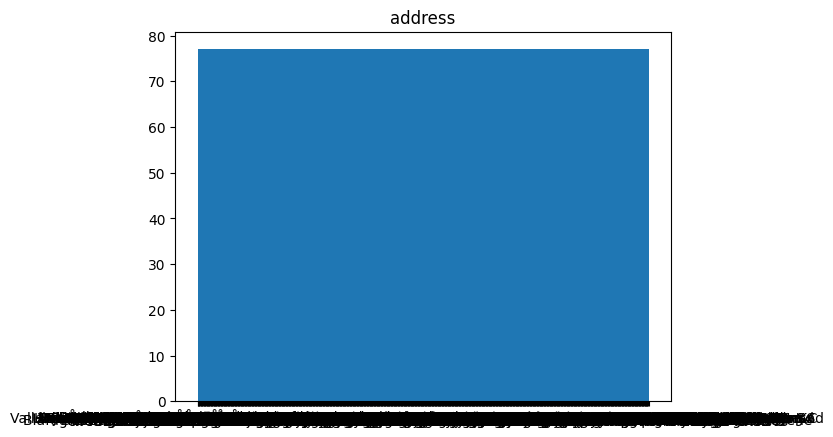

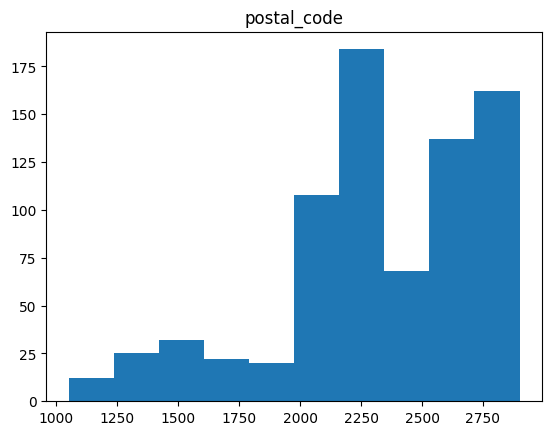

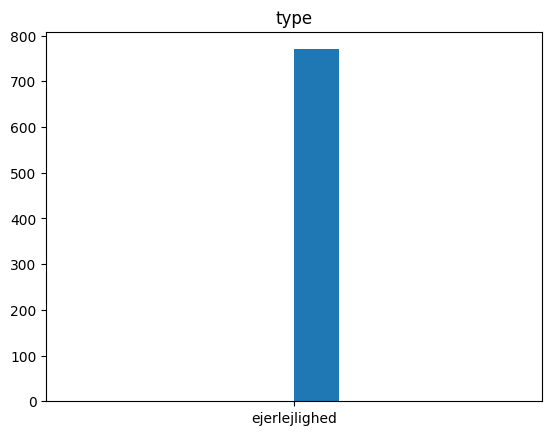

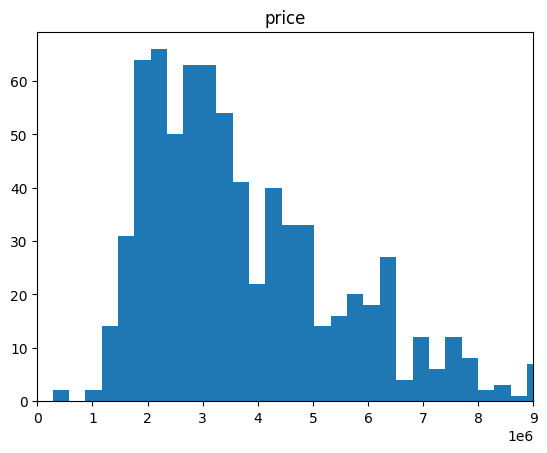

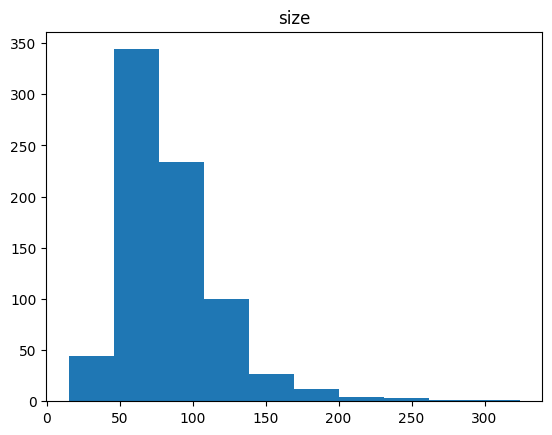

Could not plot basement_size


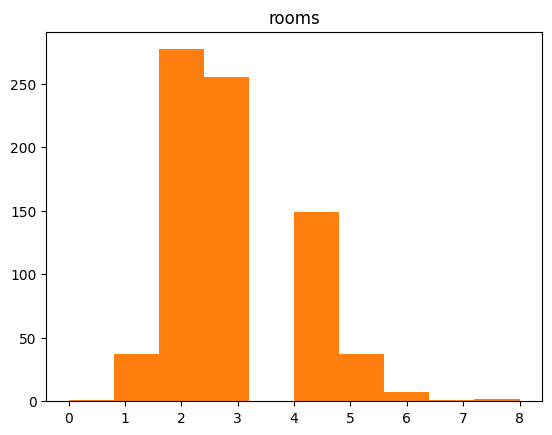

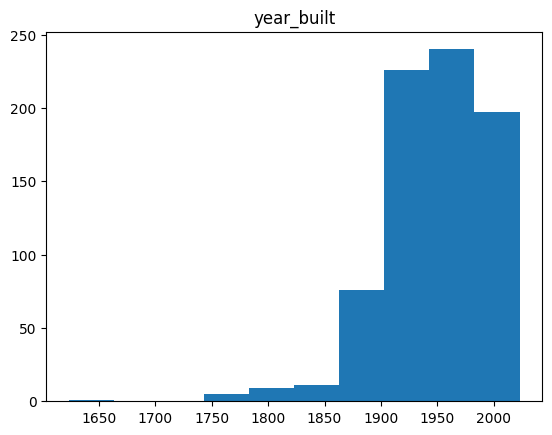

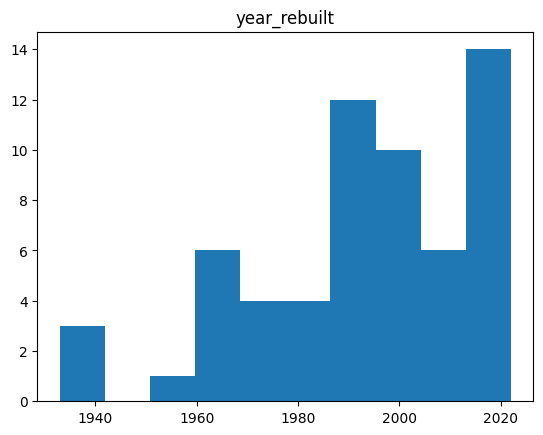

Could not plot energy_label


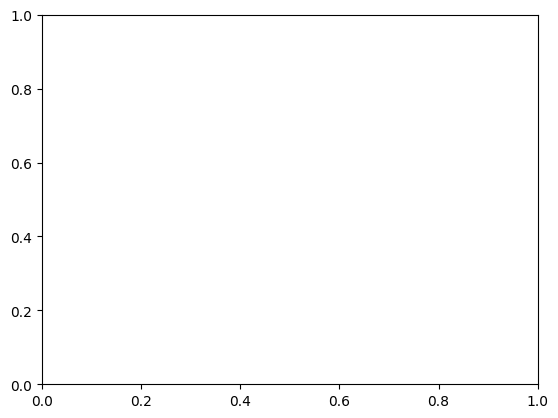

In [9]:
from utils import describe_df, plot_distributions
#houses_description = houses_df_.describe()
#print(houses_description.to_latex())
#plot_distributions(houses_df_)

In [7]:
from utils import remove_outliers
from img_utils import preprocess_images

# #Take only Copenhagen, and Ejerlejligheder
# houses_df = houses_df[(houses_df['postal_code'] >= 1000) & (houses_df['postal_code'] <= 2920)]
# houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']

# #Remove theoutliers 
# houses_df = remove_outliers(houses_df, 'price')

# #Drop houses with no floorplan
# houses_df = houses_df.dropna(subset=['image_floorplan'])

In [8]:
import numpy as np
import pandas as pd
#Set the basement_size to 0 if it is NaN
# houses_df['basement_size'] = houses_df['basement_size'].fillna(0)

# #Set the year_rebuilt to year_built if it is NaN
# houses_df['year_rebuilt'] = houses_df['year_rebuilt'].fillna(houses_df['year_built'])

# #Encode the features: postal_code, type, energy_class
# houses_df['postal_code'] = houses_df['postal_code'].astype('category').cat.codes
# houses_df['type'] = houses_df['type'].astype('category').cat.codes
# houses_df['energy_label'] = houses_df['energy_label'].astype('category').cat.codes

# #Drop Adress
# houses_df = houses_df.drop(columns=['address'])

In [13]:
from sklearn.model_selection import train_test_split
from utils import prepare_features
houses_df = prepare_features(houses_df_)
print("Number of Datapoints: ", len(houses_df))

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.15, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.15, random_state=0)
train1_df, train2_df = train_test_split(train_df, test_size=0.45, random_state=0)

Number of Datapoints:  749


In [306]:
print(len(train1_df), len(train2_df), len(valid_df), len(test_df))

297 243 96 113


In [84]:
display(train_df.head(1))

,postal_code,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
480,1.347921,-0.166018,1.001289,0.0,1.069555,-0.144463,-0.256289,1.444969,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


# Feeding Vision Prediction into Random Forrest

In [6]:
from keras.applications import VGG16
from keras.models import Model, load_model
from sklearn.ensemble import RandomForestRegressor
from utils import plot_regression_results, regression_stats, feature_importance
from multiprocessing import Process
from sklearn import linear_model
import pandas as pd

def flatten_features(features):
    num_samples = features.shape[0]
    flattened_features = features.reshape(num_samples, -1)
    return flattened_features

def feature_extraction_vgg16(image_data):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    features = model.predict(image_data)
    return features

def feature_extraction_custom_model(image_data, model, layer_index):
    """Extract features from a custom model, based on a specified layer"""
    num_layers = len(model.layers)
    adjusted_index = num_layers - layer_index - 1
    print(f"Selected layer: {model.layers[adjusted_index].name}")
    
    features = model.layers[adjusted_index].output
    model = Model(inputs=model.inputs, outputs=features)
    features = model.predict(image_data)
    return features

def random_forest_prediction_with_feature_importance(train_df, valid_df, test_df, 
                                                     target_width, target_height, 
                                                     resize, gray_scale, threshold, 
                                                     use_model, custom_model_path, use_custom_model=False, layer_index=0):
    if use_model:
        if use_custom_model:
            vision_model = load_model(custom_model_path)
            print(vision_model.summary())
            train_features = feature_extraction_custom_model(preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), vision_model, layer_index)
            test_features = feature_extraction_custom_model(preprocess_images(test_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), vision_model, layer_index)
        else:
            train_features = feature_extraction_vgg16(preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold))
            test_features = feature_extraction_vgg16(preprocess_images(test_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold))

        print(f"Train features shape: {train_features.shape}")
        print(f"Test features shape: {test_features.shape}")
        
        train_features_flat = flatten_features(train_features)
        test_features_flat = flatten_features(test_features)
        
        train_features_df = pd.DataFrame(train_features_flat, index=train_df.index)
        test_features_df = pd.DataFrame(test_features_flat, index=test_df.index)

        # Name the new features
        feature_names = [f'vision_feature_{i}' for i in range(train_features_flat.shape[1])]
        train_features_df.columns = feature_names
        test_features_df.columns = feature_names
        
        train_df = pd.concat([train_df, train_features_df], axis=1)
        test_df = pd.concat([test_df, test_features_df], axis=1)

    #Split up the train data into 2 parts. 

    # Setup Training Data
    x_train = train_df.drop(columns=['image_floorplan', 'price'])
    y_train = train_df['price']
    x_test = test_df.drop(columns=['image_floorplan', 'price'])
    y_test = test_df['price']
    
    # Train model with RandomForestRegressor
    forest = RandomForestRegressor(random_state=0)
    forest.fit(x_train, y_train)
    
    # Get feature importances
    feature_importances = forest.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    
    # Select top features
    num_selected_features = 100
    selected_feature_indices = sorted_indices[:num_selected_features]
    x_train_selected = x_train.iloc[:, selected_feature_indices]
    x_test_selected = x_test.iloc[:, selected_feature_indices]
    
    # Train model with selected features
    forest_selected = RandomForestRegressor(random_state=0)
    #Turn forest_selected into regression 
    forest_selected = linear_model.LinearRegression()
    forest_selected.fit(x_train_selected, y_train)
    
    y_test_pred = forest_selected.predict(x_test_selected)

    regression_stats(y_test, y_test_pred)
    plot_regression_results('Random Forest Regression with Feature Importance', y_test, y_test_pred)
    feature_importance(forest, x_train)

In [7]:
target_width = 224
target_height = 224
resize = True
gray_scale = False
threshhold = True
scale = False

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               25690624  
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                      

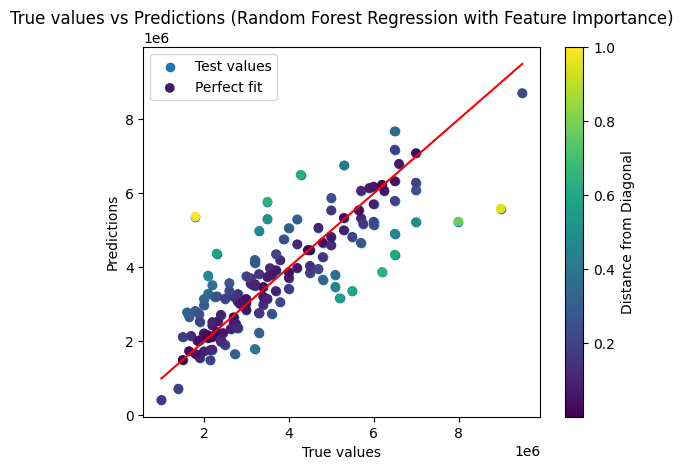

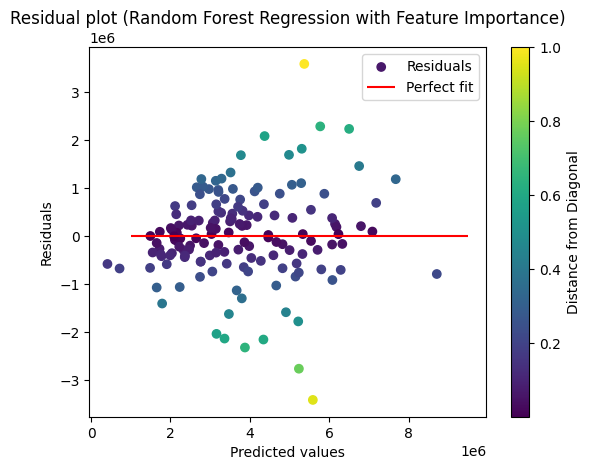

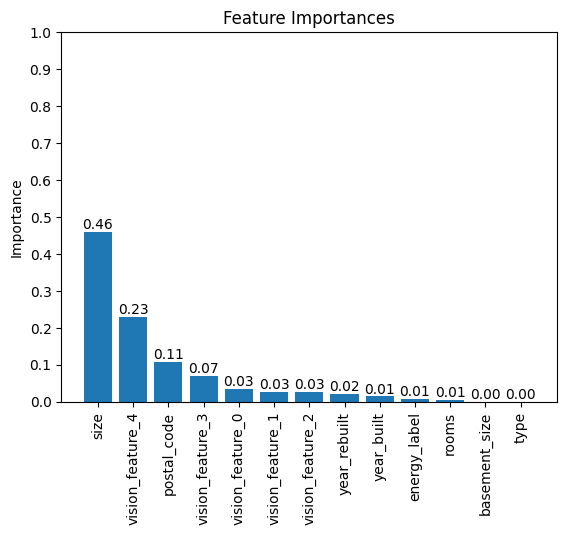

In [8]:

model_path = "trained_models/mobilenet_5_label.keras"
random_forest_prediction_with_feature_importance(train_df, valid_df, test_df, 
                                                target_width, target_height, 
                                                resize, gray_scale, threshhold,
                                                use_model=True, 
                                                custom_model_path = model_path,
                                                use_custom_model=True, 
                                                layer_index=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 28224)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               14451200  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

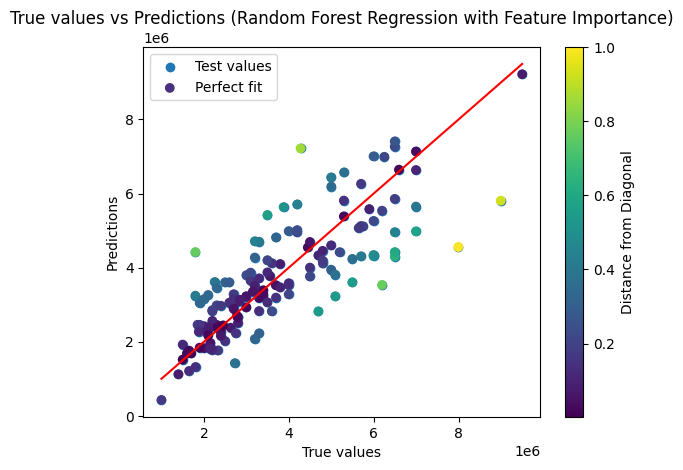

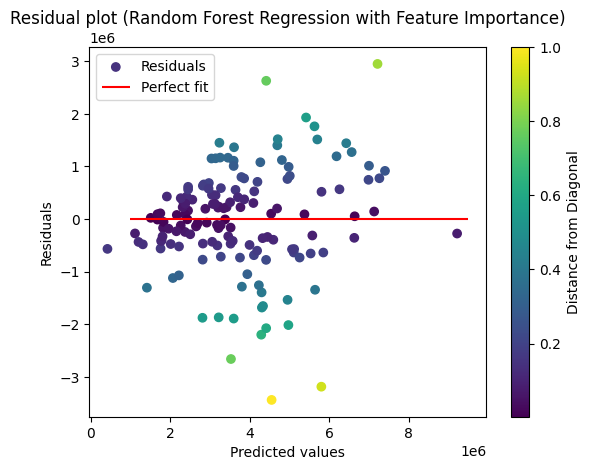

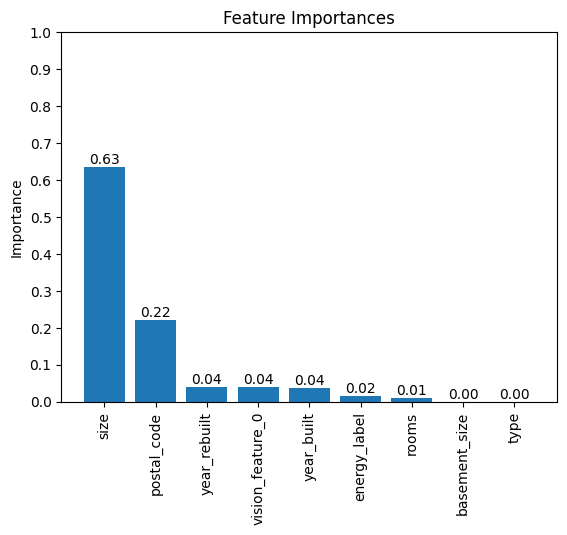

In [10]:
model_path = "trained_models/MobileNet_Continous.keras"
random_forest_prediction_with_feature_importance(train_df, valid_df, test_df, 
                                                224, 224, 
                                                resize, gray_scale, threshhold,
                                                use_model=True, 
                                                custom_model_path = model_path,
                                                use_custom_model=True, 
                                                layer_index=0)

# Vision and RF Combined 

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor

In [13]:
def comb_model(pretrained_vision_model, train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold):

# No model
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, False))
p.start()
p.join()

# Base VGG16 model
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True))
p.start()
p.join()

# Transfer learned mode with layer index 0
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 0))
p.start()
p.join()

# Transfer learned mode with layer index 2
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 2))
p.start()
p.join()

# Transfer learned mode with layer index 4
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 4))
p.start()
p.join()


IndentationError: expected an indented block after function definition on line 1 (163401419.py, line 4)

# Vision Transformers + Random Forrest

In [9]:
from transformers import AutoImageProcessor, TFViTForImageClassification, ViTForImageClassification
from transformers import pipeline

# Load the image processor
vit_model_path = "vit-base-beans"
model = ViTForImageClassification.from_pretrained(vit_model_path)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#Image preprocessing
target_height = 224
target_width = 224
resize = True
gray_scale = False
threshhold = True

train_images = preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshhold)
valid_images = preprocess_images(valid_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshhold)

image_processor = AutoImageProcessor.from_pretrained(vit_model_path)
train_images = image_processor(train_images, return_tensors="pt")
valid_images = image_processor(valid_images, return_tensors="pt")

In [11]:
#load model 
model = ViTForImageClassification.from_pretrained(vit_model_path)

In [ ]:
train_image_predictions = model(train_images.pixel_values)

In [ ]:
valid_image_predictions = model(valid_images.pixel_values)

In [ ]:
#get the percentaages 
train_image_predictions = train_image_predictions.logits.softmax(dim=-1)
valid_image_predictions = valid_image_predictions.logits.softmax(dim=-1)

In [ ]:
#Add the predictions to the dataframe, as 6 new columns
for i in range(6):
  train_df[f'vit_prediction_{i}'] = train_image_predictions.detach().numpy()[:, i]
  valid_df[f'vit_prediction_{i}'] = valid_image_predictions.detach().numpy()[:, i]

In [ ]:
display(train_df.head())

,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,vit_prediction_0,vit_prediction_1,vit_prediction_2,vit_prediction_3,vit_prediction_4,vit_prediction_5
204,57,0,4450000,112,0,3,2010,2010.0,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.045315,0.117218,0.203138,0.409715,0.183556,0.041059
66,35,0,3395000,50,0,2,1963,1963.0,5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.089265,0.112384,0.359536,0.167215,0.240058,0.031542
177,55,0,2895000,78,0,3,1962,1962.0,5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.188455,0.330409,0.143624,0.253240,0.057929,0.026342
113,39,0,2595000,67,0,3,1949,1949.0,5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.178981,0.361435,0.139739,0.234367,0.055864,0.029615
29,21,0,5795000,94,0,3,1905,1905.0,5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.045752,0.089568,0.217710,0.320622,0.294746,0.031603


In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Get features of dataframe 
X_train = train_df.drop(columns=['image_floorplan', 'price'])
X_valid = valid_df.drop(columns=['image_floorplan', 'price'])
y_train = train_df['price']
y_valid = valid_df['price']

# Train model with RandomForestRegressor
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

vit_prediction_4: 0.6234056061377178
vit_prediction_0: 0.19660173852646518
vit_prediction_1: 0.05034592532387695
vit_prediction_2: 0.03200440954841377
postal_code: 0.025752471420256072
size: 0.02121754756198876
vit_prediction_3: 0.020299599770810427
vit_prediction_5: 0.008557396374610313
year_built: 0.007104199681906193
energy_label: 0.006342844981047798
rooms: 0.004532254336143463
year_rebuilt: 0.0038360063367632344
basement_size: 0.0
type: 0.0


Mean Squared Error: 3013358865181.8184
Mean Absolute Error: 1325035.4545454546
R^2: 0.4043938858063938


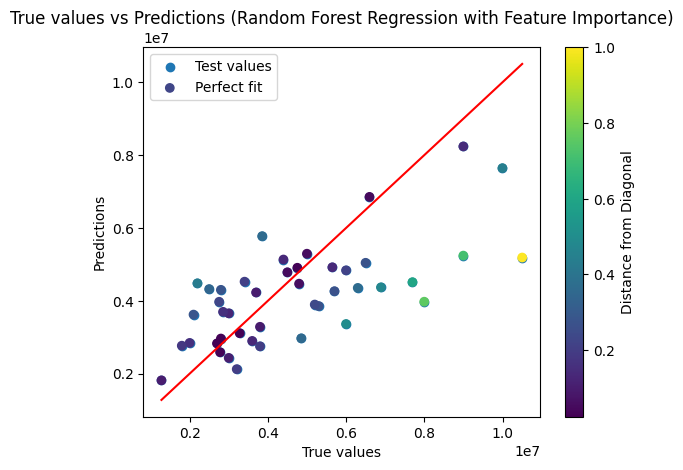

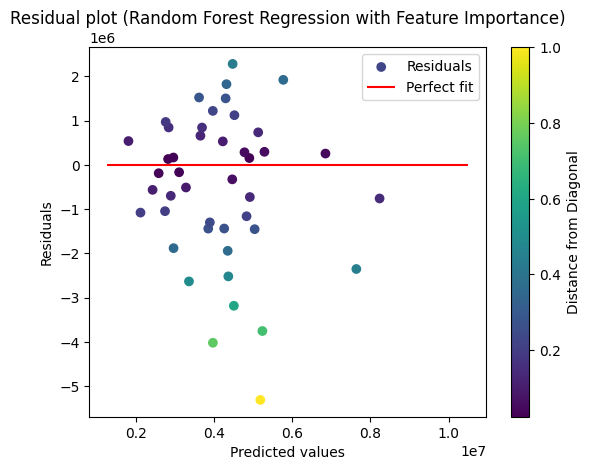

In [ ]:
#Evaluate the model 
y_valid_pred = forest.predict(X_valid)

#Print all features 
#Get feature importances
feature_importances = forest.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
for i in range(len(sorted_indices)):
  print(f"{X_train.columns[sorted_indices[i]]}: {feature_importances[sorted_indices[i]]}")

print("\n")
regression_stats(y_valid, y_valid_pred)
plot_regression_results('Random Forest Regression with Feature Importance', y_valid, y_valid_pred)

In [ ]:
from transformers import AutoImageProcessor, TFViTForImageClassification, ViTForImageClassification
from transformers import pipeline

def vit_rf(vit_model_path, 
           train_data, valid_data, test_data,
           target_width, target_height,
           resize, gray_scale, threshold):

  #preprocess the images
  image_processor = AutoImageProcessor.from_pretrained(vit_model_path, from_pt=True)
  train_images = image_processor(preprocess_images(train_data, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), return_tensors="pt")
  valid_images = image_processor(preprocess_images(valid_data, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), return_tensors="pt")
  test_images = image_processor(preprocess_images(test_data, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), return_tensors="pt")

  
  #load model 
  model = ViTForImageClassification.from_pretrained(vit_model_path)

  #get the first prediction
  train_image_predictions = model(**train_images).logits
  valid_image_predictions = model(**valid_images).logits
  #Gather X_train and Y_train 
  train_df = train_data.drop(columns=['image_floorplan', 'price'])
  train_df['image_predictions'] = train_image_predictions.detach().numpy().tolist()
  y_train = train_data['price']

  #Gather X_valid and Y_valid
  valid_df = valid_data.drop(columns=['image_floorplan', 'price'])
  valid_df['image_predictions'] = valid_image_predictions.detach().numpy().tolist()
  y_valid = valid_data['price']

  display(train_df.head())
  #Train the model
  #forest = RandomForestRegressor(random_state=0)
  #forest.fit(train_df, y_train)

  return None


vit_model_path = "vit-base-beans"
vit_rf(vit_model_path, 
       train_df, valid_df, test_df, 
       target_width=224, target_height=224, resize=True, gray_scale=False, threshold=True
       )  

KeyboardInterrupt: 

# SiFT + Features + MobileNet 

In [ ]:
import joblib
from img_utils import create_bow_representation
from sklearn.ensemble import RandomForestRegressor

def Create_Multi_Model(model_list, input_list, target_list):
  """
  Takes a list of models, and a list of inputs. Run each model on each input, and input that into a new RF. Train the new RF. 
  """
  #Create a new dataframe
  new_df = pd.DataFrame()
  for model, input in zip(model_list, input_list):
    model_name = "model_" + str(model_list.index(model))
    predictions = model.predict(input).flatten()
    new_df[model_name] = predictions
  
  #Train a new RF on the new dataframe
  y_train = target_list
  X_train = new_df
  forest = RandomForestRegressor(random_state=0, n_estimators=1000)
  forest.fit(X_train, y_train)
  #print feature importances 
  feature_importance(forest, X_train)
  return forest

In [ ]:
#Load the Models
RF_model = joblib.load('trained_models/forest_model.pkl')
MN_model = load_model('trained_models/MobileNet_Continous.keras')
BoW_model = joblib.load('trained_models/RF_BoW.pkl')
XGB_model = joblib.load('trained_models/xgb_model.pkl')
models_list = [BoW_model, MN_model, RF_model, XGB_model]

In [23]:
#Load the Inputs for each model 
RF_input = valid_df.drop(columns=['image_floorplan', 'price'])
MN_input = preprocess_images(valid_df, 'image_floorplan', 224, 224, True, False, False)
BoW_input = [x.flatten() for x in create_bow_representation(MN_input)]
inputs_list = [BoW_input, MN_input, RF_input, RF_input]

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


2/2 [==============================] - 6s 626ms/step


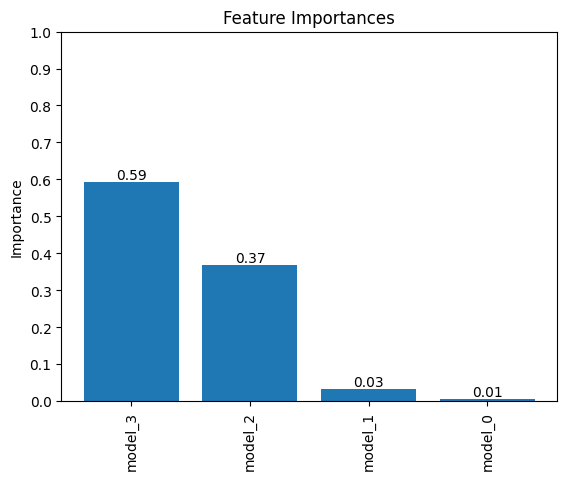

In [ ]:
#Create the combined model 
combined_model = Create_Multi_Model(models_list, inputs_list, valid_df['price'])

3/3 [==============================] - 9s 2s/step
Mean Squared Error: 329942625374.2
Mean Absolute Error: 342761.6461538462
R^2: 0.9150670644204018


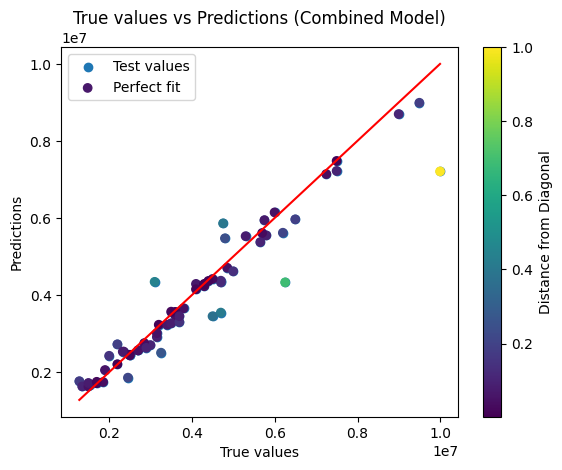

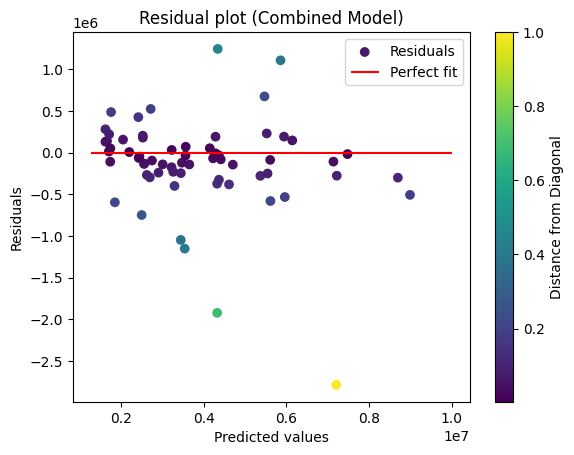

In [ ]:
#Predict the test prices 
RF_test_input = test_df.drop(columns=['image_floorplan', 'price'])
MN_test_input = preprocess_images(test_df, 'image_floorplan', 400, 400, True, True, False)
BoW_test_input = [x.flatten() for x in create_bow_representation(MN_test_input)]

RF_test_output = RF_model.predict(RF_test_input)
MN_test_output = MN_model.predict(MN_test_input).flatten()
BoW_test_output = BoW_model.predict(BoW_test_input)
XGB_test_output = XGB_model.predict(RF_test_input)

combined_test_output = pd.DataFrame({'model_0':BoW_test_output, 'model_1':MN_test_output, 'model_2':RF_test_output, 'model_3':XGB_test_output})

#Predict the test prices
combined_test_predictions = combined_model.predict(combined_test_output[['model_0', 'model_1', 'model_2', 'model_3']])
regression_stats(test_df['price'], combined_test_predictions)
plot_regression_results('Combined Model', test_df['price'], combined_test_predictions)

In [ ]:
# Get the 5 worst predictions 
worst_predictions = test_df.copy()
worst_predictions['predictions'] = combined_test_predictions
worst_predictions['error'] = abs(worst_predictions['price'] - worst_predictions['predictions'])
worst_predictions = worst_predictions.sort_values(by='error', ascending=False)
worst_predictions.head(5)


,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,predictions,error
22,34,0,9995000,122,0,4,1900,1900.0,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",7264355.0,2730645.0
17,38,0,6250000,92,0,2,2006,2006.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4292430.0,1957570.0
165,49,0,3095000,117,0,3,1987,1987.0,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4347005.0,1252005.0
106,36,0,4750000,111,0,4,2017,2017.0,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",5942500.0,1192500.0
26,57,0,4695000,75,0,2,1987,1987.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3727960.0,967040.0


# Loading From Model.py

In [14]:
from models import *
from img_utils import *
from utils import *

train_prices = train_df['price']
train_features = train_df.drop(columns=['image_floorplan', 'price'])
train_images_224 = preprocess_images(train_df, 'image_floorplan', 224, 224, True, False, False)
train_images_448 = preprocess_images(train_df, 'image_floorplan', 448, 448, True, False, False)

#Used to train image models
train1_prices = train1_df['price']
train1_features = train1_df.drop(columns=['image_floorplan', 'price'])
train1_images_224 = preprocess_images(train1_df, 'image_floorplan', 224, 224, True, False, False)
train1_images_299 = preprocess_images(train1_df, 'image_floorplan', 299, 299, True, False, False)
train1_images_448 = preprocess_images(train1_df, 'image_floorplan', 448, 448, True, False, False)

#Used to train ensemble methods 
train2_prices = train2_df['price']
train2_features = train2_df.drop(columns=['image_floorplan', 'price'])
train2_images_224 = preprocess_images(train2_df, 'image_floorplan', 224, 224, True, False, False)
train2_images_299 = preprocess_images(train2_df, 'image_floorplan', 299, 299, True, False, False)
train2_images_448 = preprocess_images(train2_df, 'image_floorplan', 448, 448, True, False, False)

valid_prices = valid_df['price']
valid_features = valid_df.drop(columns=['image_floorplan', 'price'])
valid_images_224 = preprocess_images(valid_df, 'image_floorplan', 224, 224, True, False, False)
valid_images_299 = preprocess_images(valid_df, 'image_floorplan', 299, 299, True, False, False)
valid_images_448 = preprocess_images(valid_df, 'image_floorplan', 448, 448, True, False, False)

test_prices = test_df['price']
test_features = test_df.drop(columns=['image_floorplan', 'price'])
test_images_224 = preprocess_images(test_df, 'image_floorplan', 224, 224, True, False, False)
test_images_299 = preprocess_images(test_df, 'image_floorplan', 299, 299, True, False, False)
test_images_448= preprocess_images(test_df, 'image_floorplan', 448, 448, True, False, False)

num_labels = 8
all_prices = np.concatenate((train1_prices, valid_prices, test_prices))
train1_labels =  prices_to_n_labels(all_prices, train1_prices, num_labels)
valid_labels = prices_to_n_labels(all_prices, valid_prices, num_labels)
test_labels = prices_to_n_labels(all_prices, test_prices, num_labels)

[1995000.0, 2457500.0, 2995000.0, 3495000.0, 4295000.0, 4998000.0, 6495000.0]
[1995000.0, 2457500.0, 2995000.0, 3495000.0, 4295000.0, 4998000.0, 6495000.0]
[1995000.0, 2457500.0, 2995000.0, 3495000.0, 4295000.0, 4998000.0, 6495000.0]


### Features Models

Running RF on Features:


,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label
651,1.395081,0.825871,0.0,0.119115,-1.282717,-1.414047,0.923833


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

Params for model {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500}
R^2: 0.8237972670503371
Mean Absolute Error: 591513.4763727669
Mean Percentage Error: 18.013401109306482
Mean Squared Error: 869602714217.801


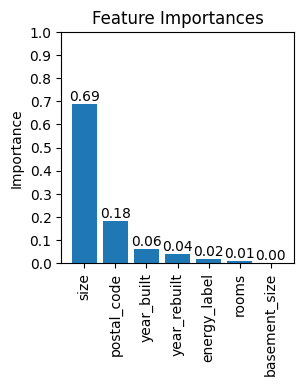

In [26]:
from models import RF
#Set ignore fuiture warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
RF_model = RF(train_features, train_prices, test_features, test_prices)

R^2: 0.7944895204363409
Mean Absolute Error: 558431.483180428
Mean Percentage Error: 14.384827790234276
Mean Squared Error: 619057777061.6462


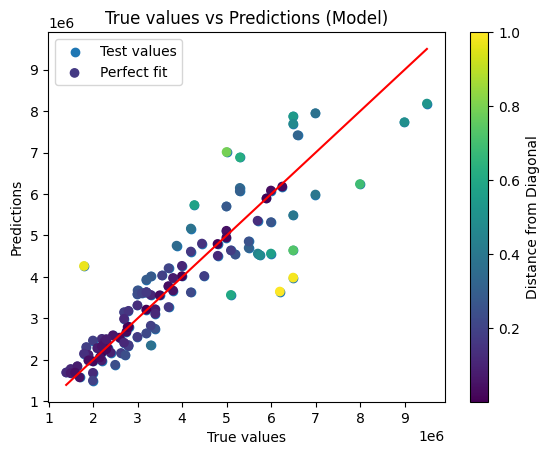

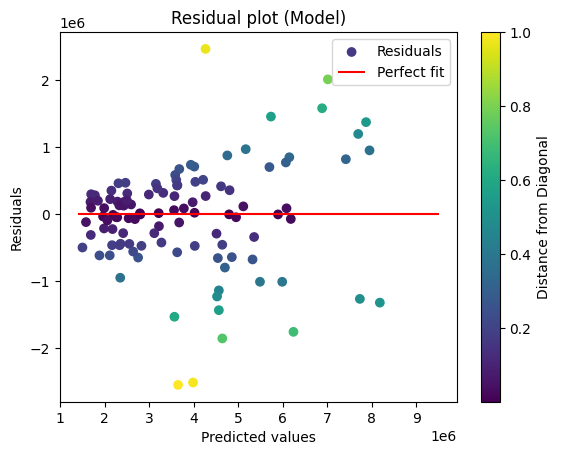

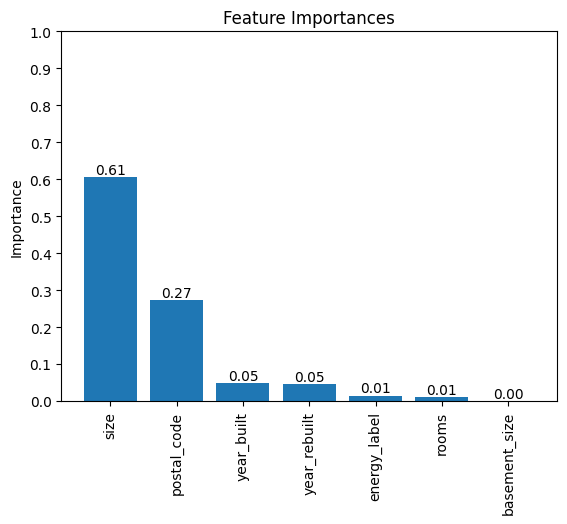

In [108]:
RF_model_full_data = RF(train_features, train_prices, test_features, test_prices)

Results
R^2: 0.713945005673952
Mean Absolute Error: 670046.4151376147
Mean Percentage Error: 16.928679095741657
Mean Squared Error: 861681454302.7294


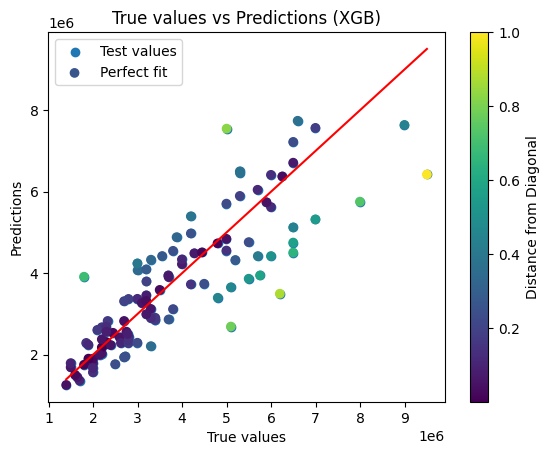

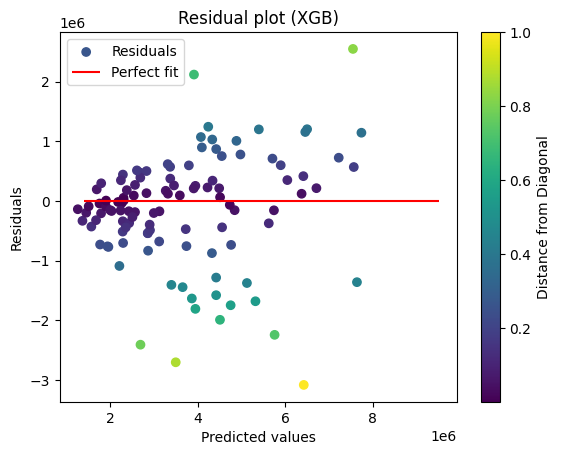

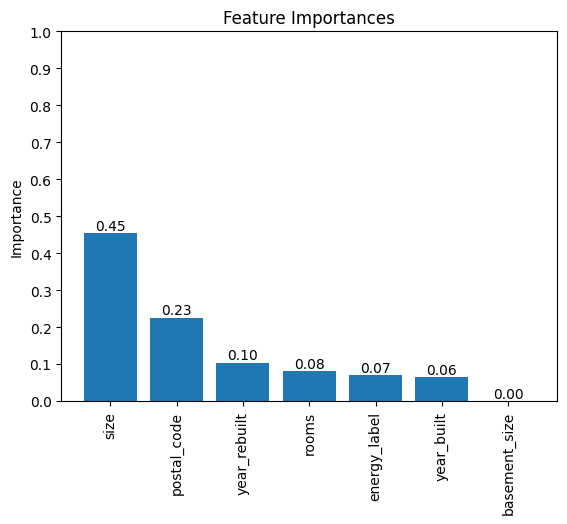

R^2: 0.743683309383498
Mean Absolute Error: 644367.0927419355
Mean Percentage Error: 16.2803831008865
Mean Squared Error: 900943080392.799


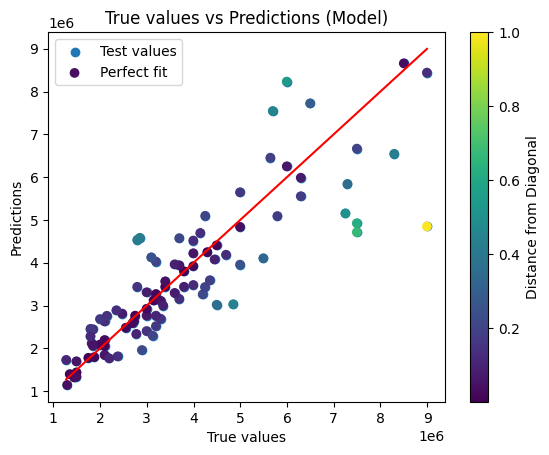

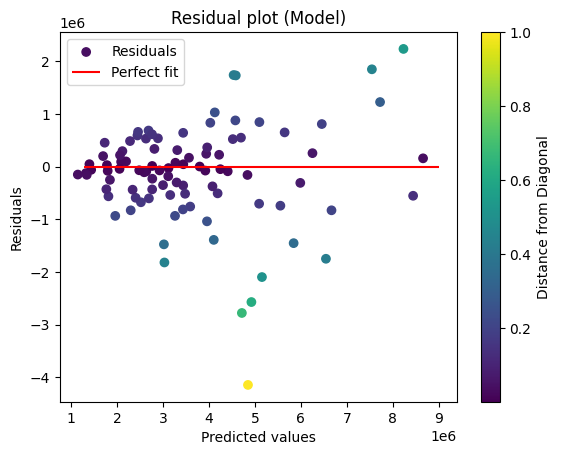

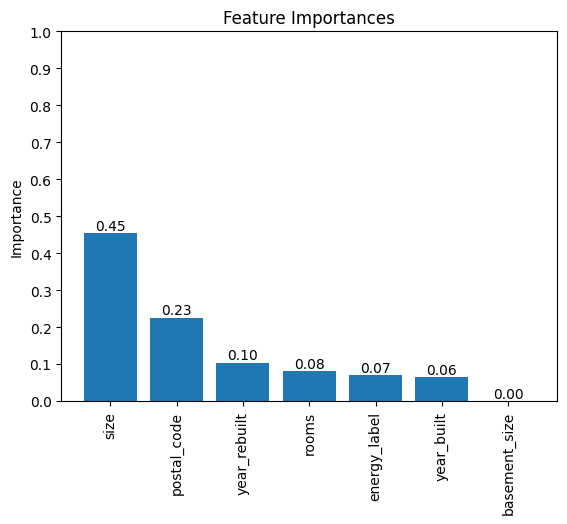

In [72]:
XGB_model = XGB(train2_features, train2_prices, test_features, test_prices)

### Vision Models 

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications import NASNetMobile

##### CNN - Continoues

In [32]:
from models import CNN_model
MobileNet_Model, MobileNet_fit_hist = CNN_model(MobileNetV3Small, train1_images_224, train1_prices, valid_images_224, valid_prices)

Epoch 1/150
10/10 [==============================] - 23s 1s/step - loss: 4113117.0000 - mean_absolute_error: 4112414.2500 - val_loss: 3964118.7500 - val_mean_absolute_error: 3963727.2500
Epoch 2/150
10/10 [==============================] - 7s 704ms/step - loss: 4112701.2500 - mean_absolute_error: 4112405.0000 - val_loss: 3963910.0000 - val_mean_absolute_error: 3963702.7500
Epoch 3/150
10/10 [==============================] - 7s 753ms/step - loss: 4112572.2500 - mean_absolute_error: 4112377.5000 - val_loss: 3963757.0000 - val_mean_absolute_error: 3963573.0000
Epoch 4/150
10/10 [==============================] - 7s 708ms/step - loss: 4112500.2500 - mean_absolute_error: 4112304.2500 - val_loss: 3963489.2500 - val_mean_absolute_error: 3963263.7500
Epoch 5/150
10/10 [==============================] - 7s 682ms/step - loss: 4112414.2500 - mean_absolute_error: 4112152.5000 - val_loss: 3962904.0000 - val_mean_absolute_error: 3962576.2500
Epoch 6/150
10/10 [==============================] - 7s 6

In [226]:
eval_model(MobileNet_Model, test_images_224, test_prices)
eval_model(MobileNet_Model, train2_images_224, train2_prices)

4/4 [==============================] - 7s 292ms/step
R^2: 0.05654544826716068
Mean Absolute Error: 1171015.8109157889
Mean Percentage Error: 33.17476529052367
Mean Squared Error: 2599148904607.88
8/8 [==============================] - 3s 330ms/step
R^2: 0.18777350758113853
Mean Absolute Error: 1104513.6553030303
Mean Percentage Error: 31.653751504055744
Mean Squared Error: 2260719758932.709


Epoch 1/100
9/9 [==============================] - 71s 5s/step - loss: 3796074.7500 - mean_squared_error: 17512602271744.0000 - mean_absolute_error: 3796074.7500 - val_loss: 3793046.0000 - val_mean_squared_error: 17902098972672.0000 - val_mean_absolute_error: 3793046.0000
Epoch 2/100
9/9 [==============================] - 36s 4s/step - loss: 3791357.7500 - mean_squared_error: 17477140480000.0000 - mean_absolute_error: 3791357.7500 - val_loss: 3784658.5000 - val_mean_squared_error: 17838332968960.0000 - val_mean_absolute_error: 3784658.5000
Epoch 3/100
9/9 [==============================] - 35s 4s/step - loss: 3778969.2500 - mean_squared_error: 17383252033536.0000 - mean_absolute_error: 3778969.2500 - val_loss: 3766045.5000 - val_mean_squared_error: 17697314177024.0000 - val_mean_absolute_error: 3766045.5000
Epoch 4/100
9/9 [==============================] - 35s 4s/step - loss: 3754343.5000 - mean_squared_error: 17198860992512.0000 - mean_absolute_error: 3754343.5000 - val_loss: 3731149

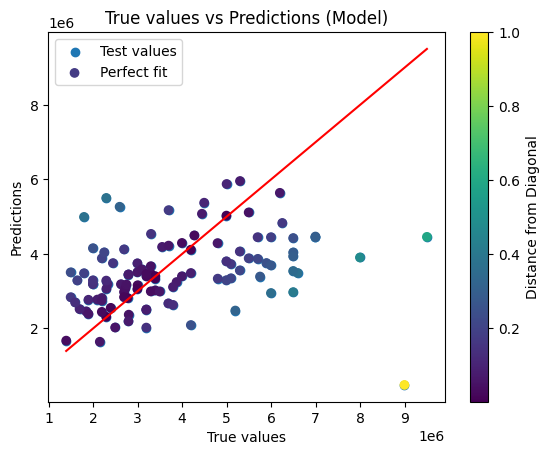

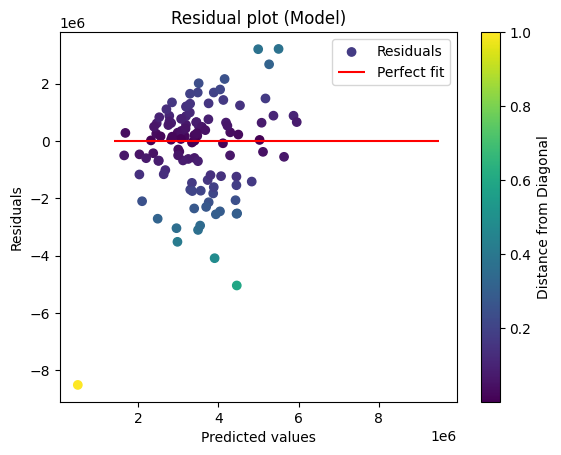

Could not plot feature importances for model <keras.src.engine.sequential.Sequential object at 0x198530910>


In [161]:
EfficientNetV2S_Model, EfficientNetV2S_Model_fit_hist = CNN_model(EfficientNetV2S, train1_images_224, train1_prices, valid_images_224, valid_prices)
eval_model(EfficientNetV2S_Model, test_images_224, test_prices)

4/4 [==============================] - 11s 2s/step
R^2: 0.018170873605283133
Mean Absolute Error: 1219095.2981651376
Mean Percentage Error: 33.15564185147401
Mean Squared Error: 2957556995296.76


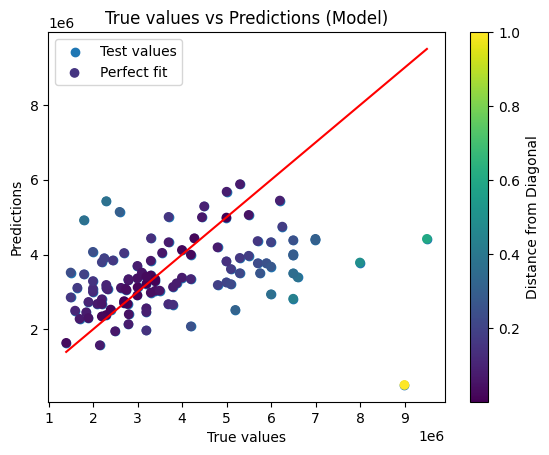

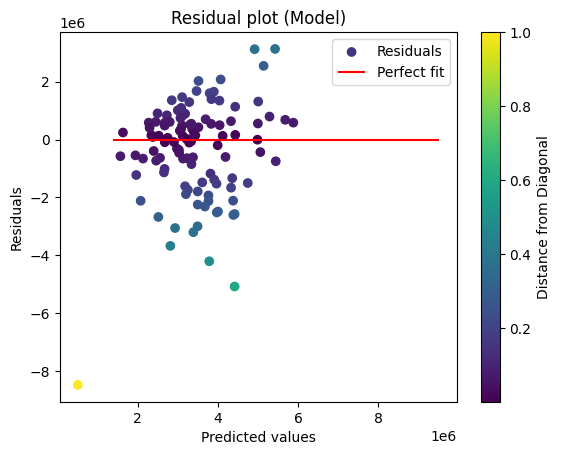

Could not plot feature importances for model <keras.src.engine.sequential.Sequential object at 0x14f8b1510>


In [143]:
eval_model(EfficientNetV2S_Model[0], test_images_224, test_prices)
#eval_model(EfficientNetV2S_Model, test_images_224, test_prices)

#### N-CNN - Continoues

In [229]:
from models import N_CNN_model
n = 3
N_CNN_Model = N_CNN_model(MobileNetV3Small, train_images_224, train_prices, valid_images_224, valid_prices, n)

Epoch 1/150
11/11 [==============================] - 28s 1s/step - loss: 3716313.0000 - mean_absolute_error: 3716164.0000 - val_loss: 3778210.7500 - val_mean_absolute_error: 3778059.5000
Epoch 2/150
11/11 [==============================] - 7s 675ms/step - loss: 3715619.2500 - mean_absolute_error: 3715467.0000 - val_loss: 3773586.2500 - val_mean_absolute_error: 3773416.0000
Epoch 3/150
11/11 [==============================] - 8s 698ms/step - loss: 3713110.2500 - mean_absolute_error: 3712908.5000 - val_loss: 3762749.2500 - val_mean_absolute_error: 3762495.0000
Epoch 4/150
11/11 [==============================] - 8s 700ms/step - loss: 3706693.7500 - mean_absolute_error: 3706386.5000 - val_loss: 3739006.0000 - val_mean_absolute_error: 3738629.2500
Epoch 5/150
11/11 [==============================] - 8s 744ms/step - loss: 3693467.5000 - mean_absolute_error: 3693032.2500 - val_loss: 3699108.5000 - val_mean_absolute_error: 3698596.5000
Epoch 6/150
11/11 [==============================] - 8s 7

#### ViT

In [73]:
from models import ViT_model
ViT_model = ViT_model(train1_images_224, train1_prices, valid_images_224, valid_prices)

1218991142/1218991142 [==============================] - 314s 0us/step


/usr/local/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "vit-l16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 1024)      787456    
                                                                 
 reshape (Reshape)           (None, 196, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 197, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 197, 1024)         201728    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)       

#### BoVW

R^2: -0.016449498747301616
Mean Absolute Error: 1553457.6702508961
Mean Percentage Error: 55.03865672905235
Mean Squared Error: 3572779986595.8184


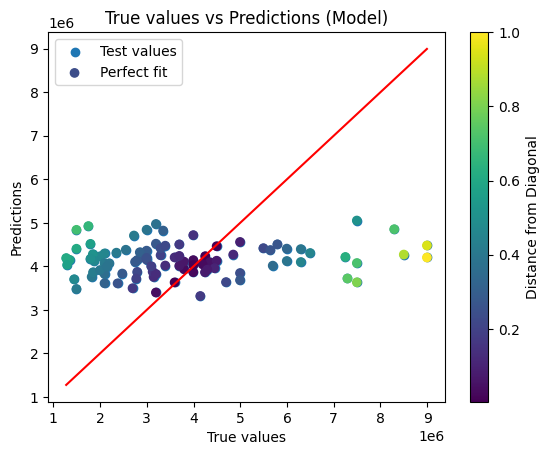

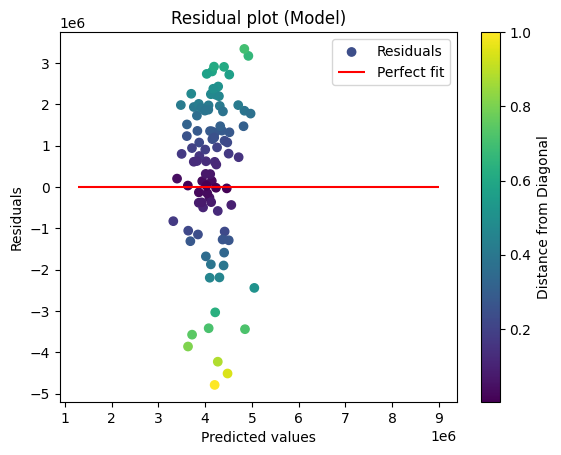

Could not plot feature importances for model RandomForestRegressor(random_state=42)


In [40]:
from models import BoVW_RF_model
BoVW_RF_model_ = BoVW_RF_model(train1_images_224, train1_prices, valid_images_224, valid_prices)

### Ensemble Methods

##### CNN Pred + Features -> RF

In [227]:
from models import CNN_RF_model 
MN_RF_Model = CNN_RF_model(MobileNet_Model, 
                           train2_images_224, train2_features, train2_prices,
                           test_images_224, test_features, test_prices)

4/4 [==============================] - 1s 317ms/step
Running RF on features:


,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_predictions
488,1.300761,-0.78213,0.0,-0.831324,-0.310027,-0.42469,-0.11844,2108384.25


,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_predictions
367,0.168919,-0.665185,0.0,0.119115,-0.123767,-0.235239,0.923833,2078962.375


R^2: 0.7122264247804977
Mean Absolute Error: 602823.3644859813
Mean Percentage Error: 19.55192840895327
Mean Squared Error: 792795340732.7103
R^2: 0.7262914296098153
Mean Absolute Error: 569540.8951935915
Mean Percentage Error: 18.4966693908001
Mean Squared Error: 754047271916.5903


#### CNN Pred + RF(Features) -> RF

In [228]:
from models import CNN_RF_model_V2
CNN_model = MobileNet_Model
RF_model = RF_model


CNN_RF_Model_v2 = CNN_RF_model_V2(CNN_model, RF_model,
                                  train2_images_224, train2_features, train2_prices,
                                  test_images_224, test_features, test_prices)

4/4 [==============================] - 1s 309ms/step
R^2: 0.8493539709668836
Mean Absolute Error: 467976.1682242991
Mean Percentage Error: 15.442218038543956
Mean Squared Error: 415018890550.4673


#### CNN + AE + Features -> RF 

In [221]:
from models import CNN_AE_RF_model
MN_AE_RF_Model = CNN_AE_RF_model(MobileNet_Model, 
                                 train2_images_224, train2_features, train2_prices,
                                 test_images_224, test_features, test_prices)

Traning AutoEncoder
Epoch 1/10
7/7 [==============================] - 14s 1s/step - loss: 0.2130 - val_loss: 0.2074
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.2059 - val_loss: 0.1969
Epoch 3/10
7/7 [==============================] - 7s 1s/step - loss: 0.1910 - val_loss: 0.1739
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.1589 - val_loss: 0.1261
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 0.0998 - val_loss: 0.0585
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.0453 - val_loss: 0.0391
Epoch 7/10
7/7 [==============================] - 8s 1s/step - loss: 0.0399 - val_loss: 0.0428
Epoch 8/10
7/7 [==============================] - 8s 1s/step - loss: 0.0412 - val_loss: 0.0399
Epoch 9/10
7/7 [==============================] - 7s 1s/step - loss: 0.0372 - val_loss: 0.0372
Epoch 10/10
7/7 [==============================] - 7s 981ms/step - loss: 0.0359 - val_loss: 0.0351
Adding AutoEncoder Recons

,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label,reconstruction_error,image_predictions
488,1.300761,-0.78213,0.0,-0.831324,-0.310027,-0.42469,-0.11844,60554.367188,1949663.5


,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label,reconstruction_error,image_predictions
367,0.168919,-0.665185,0.0,0.119115,-0.123767,-0.235239,0.923833,53885.972656,2151933.75


R^2: 0.7047267898814142
Mean Absolute Error: 606635.046728972
Mean Percentage Error: 20.184959084995985
Mean Squared Error: 813456291275.7009


#### N-CNN + Features -> RF

In [ ]:
from models import N_CNN_RF_model
#Turn combined features and test_features into a df

N_CNN_RF_Model = N_CNN_RF_model(N_CNN_Model, 
                                 train_images_224, train_features, train_prices,
                                 test_images_224, test_features, test_prices)

#### CNN + MLP 

In [294]:
from models import CNN_MLP_model

CNN_MLP_Model = CNN_MLP_model(MobileNetV3Small, 
                              train_images_224, train_features, train_prices,
                              test_images_224, test_features, test_prices)

Epoch 1/250
16/16 [==============================] - 45s 1s/step - loss: 3656416.7500 - mean_absolute_error: 3656410.0000 - val_loss: 3644658.2500 - val_mean_absolute_error: 3644654.2500
Epoch 2/250
16/16 [==============================] - 10s 598ms/step - loss: 3656413.2500 - mean_absolute_error: 3656410.5000 - val_loss: 3644657.0000 - val_mean_absolute_error: 3644654.2500
Epoch 3/250
16/16 [==============================] - 9s 605ms/step - loss: 3656412.5000 - mean_absolute_error: 3656409.7500 - val_loss: 3644656.7500 - val_mean_absolute_error: 3644654.2500
Epoch 4/250
16/16 [==============================] - 8s 536ms/step - loss: 3656412.5000 - mean_absolute_error: 3656410.2500 - val_loss: 3644656.5000 - val_mean_absolute_error: 3644654.2500
Epoch 5/250
16/16 [==============================] - 8s 523ms/step - loss: 3656412.2500 - mean_absolute_error: 3656410.2500 - val_loss: 3644655.7500 - val_mean_absolute_error: 3644654.2500
Epoch 6/250
16/16 [==============================] - 9s 

# Legacy

## CNN Continoues w. House Size Prediction as Feature

In [50]:
from models import CNN_model_size
from models import CNN_RF_Size_model_V2
from tensorflow.keras.applications import MobileNetV3Large
pretrained = MobileNetV3Small
print(len(train1_images_224))
print(len(train1_features['size']))
print(len(valid_images_224))
print(len(valid_features['size']))
CNN_model_house_size, history_fit = CNN_model_size(pretrained, train1_images_224, train1_features['size'], valid_images_224, valid_features['size'])
CNN_RF_W_size = CNN_RF_Size_model_V2(MN_Model, CNN_model_house_size,
                             train2_images_224, train2_features, train2_prices, 
                             test_images_224, test_features, test_prices)

288
288
93
93
Epoch 1/100
9/9 [==============================] - 16s 1s/step - loss: 47.2216 - mean_squared_error: 2678.9900 - mean_absolute_error: 40.5869 - val_loss: 33.2696 - val_mean_squared_error: 1071.0369 - val_mean_absolute_error: 26.8115
Epoch 2/100
9/9 [==============================] - 6s 651ms/step - loss: 28.2496 - mean_squared_error: 869.3995 - mean_absolute_error: 21.9293 - val_loss: 26.3570 - val_mean_squared_error: 712.3288 - val_mean_absolute_error: 20.2086
Epoch 3/100
9/9 [==============================] - 6s 683ms/step - loss: 24.0169 - mean_squared_error: 565.0335 - mean_absolute_error: 18.0161 - val_loss: 26.3130 - val_mean_squared_error: 735.8732 - val_mean_absolute_error: 20.5021
Epoch 4/100
9/9 [==============================] - 6s 670ms/step - loss: 19.2941 - mean_squared_error: 347.0017 - mean_absolute_error: 13.6365 - val_loss: 25.7512 - val_mean_squared_error: 748.0267 - val_mean_absolute_error: 20.2852
Epoch 5/100
9/9 [==============================] - 6s 

## CNN Softmax 

In [77]:
from models import CNN_model_labels_softmax
MN_softmax = CNN_model_labels_softmax(pretrained, num_labels, train1_images_224, train1_labels, valid_images_224, valid_labels)

Epoch 1/100
15/15 [==============================] - 103s 5s/step - loss: 254.8277 - accuracy: 0.1164 - val_loss: 219.1178 - val_accuracy: 0.0690
Epoch 2/100
15/15 [==============================] - 72s 5s/step - loss: 202.2845 - accuracy: 0.1659 - val_loss: 172.2324 - val_accuracy: 0.1034
Epoch 3/100
15/15 [==============================] - 72s 5s/step - loss: 156.1685 - accuracy: 0.1595 - val_loss: 131.8309 - val_accuracy: 0.1379
Epoch 4/100
15/15 [==============================] - 68s 5s/step - loss: 118.2381 - accuracy: 0.2112 - val_loss: 100.5198 - val_accuracy: 0.1724
Epoch 5/100
15/15 [==============================] - 67s 5s/step - loss: 89.9219 - accuracy: 0.2091 - val_loss: 77.8060 - val_accuracy: 0.1121
Epoch 6/100
15/15 [==============================] - 67s 5s/step - loss: 70.8713 - accuracy: 0.2026 - val_loss: 63.8413 - val_accuracy: 0.1293
Epoch 7/100
15/15 [==============================] - 65s 4s/step - loss: 59.2304 - accuracy: 0.2392 - val_loss: 54.3864 - val_accurac

5/5 [==============================] - 18s 3s/step
Accuracy: 0.26
Precision: 0.27
Recall: 0.26
f1: 0.24


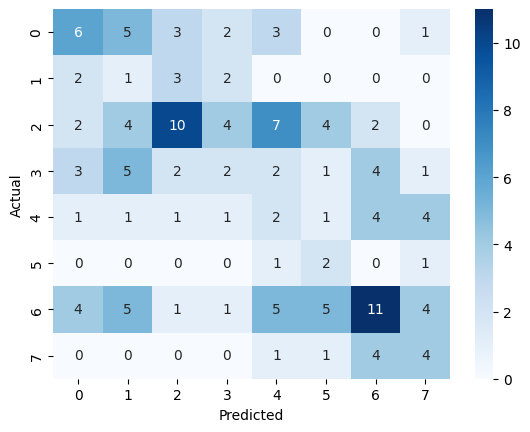

In [78]:
from img_utils import label_score_softmax
softmax_predictions = MN_softmax.predict(test_images_448)
label_score_softmax(softmax_predictions, test_labels)

##  CNN Labels

In [158]:
from models import CNN_model_labels
pretrained = MobileNetV3Small
MN_Model_labels = CNN_model_labels(pretrained,
                                   num_labels, 
                                   train1_images_224, 
                                   train1_labels, valid_images_224, valid_labels)

Epoch 1/100
15/15 [==============================] - 21s 975ms/step - loss: 232.0166 - accuracy: 0.1444 - val_loss: 187.5228 - val_accuracy: 0.1379
Epoch 2/100
15/15 [==============================] - 10s 666ms/step - loss: 161.9468 - accuracy: 0.1466 - val_loss: 131.3269 - val_accuracy: 0.1724
Epoch 3/100
15/15 [==============================] - 14s 920ms/step - loss: 110.2848 - accuracy: 0.1638 - val_loss: 86.4532 - val_accuracy: 0.1293
Epoch 4/100
15/15 [==============================] - 10s 660ms/step - loss: 70.3280 - accuracy: 0.2263 - val_loss: 52.9329 - val_accuracy: 0.1638
Epoch 5/100
15/15 [==============================] - 8s 566ms/step - loss: 41.8730 - accuracy: 0.2284 - val_loss: 30.6765 - val_accuracy: 0.1897
Epoch 6/100
15/15 [==============================] - 8s 566ms/step - loss: 24.6229 - accuracy: 0.2586 - val_loss: 19.5318 - val_accuracy: 0.1638
Epoch 7/100
15/15 [==============================] - 9s 598ms/step - loss: 16.4830 - accuracy: 0.2802 - val_loss: 13.6436

5/5 [==============================] - 5s 302ms/step
[5 0 0 6 5 1 1 2 4 4 3 1 3 7 2 1 2 4 5 1 5 5 1 1 5 7 0 0 6 7 3 2 6 2 7 4 1
 4 0 1 0 2 1 7 1 2 1 4 1 4 4 4 3 1 6 4 0 4 4 2 3 7 1 2 4 1 7 3 1 2 2 2 0 4
 4 1 6 6 0 6 3 7 4 2 4 4 4 5 7 2 3 5 5 0 6 2 1 2 1 5 2 7 7 4 1 3 1 6 6 6 3
 3 7 1 1 0 6 4 5 7 5 0 4 4 4 0 4 2 3 7 1 7 4 1 3 3 7 4 7 1 0 3 2 6 4 5]
<built-in method argmax of numpy.ndarray object at 0x15268c0f0>
Accuracy: 0.20
Precision: 0.20
Recall: 0.20


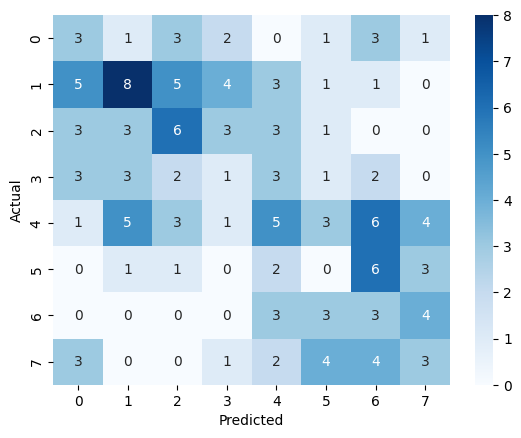

In [159]:
from img_utils import label_score 
predicted_labels = MN_Model_labels.predict(test_images_224).argmax(axis=1)
label_score(predicted_labels, test_labels.argmax(axis=1))